# Exploratory Data Analysis

On the dataset_cleaned_heartless.pkl file

In [2]:
# packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

In [3]:
dataset_heartless_path = Path('../dataset/sa/dataset_cleaned_heartless.pkl').resolve()

dataset = pd.read_pickle(dataset_heartless_path)
# dataset = dataset.sample(frac=p)      # no sampling is needed

# convert the text to string object
dataset['review_text'] = dataset['review_text'].astype('str')

# drop any duplicate just in case
dataset = dataset.drop_duplicates(keep='first')

# replace -1 to 0
# then 0 = negative, 1 = positive
# for easier processing
dataset['review_score'] = dataset['review_score'].replace(-1, 0)

# 4891928 -> 4891746 (some rows have all whitespaces)
dataset['num_of_words'] = dataset['review_text'].apply(lambda x:len(str(x).split()))
dataset = dataset[dataset['num_of_words'] > 0]

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4891746 entries, 0 to 4891927
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   index         int64 
 1   app_id        int64 
 2   app_name      object
 3   review_text   object
 4   review_score  int64 
 5   review_votes  int64 
 6   num_of_words  int64 
dtypes: int64(5), object(2)
memory usage: 298.6+ MB


We will see the ratio between positive and negative reviews

In [4]:
temp = dataset.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,780949
1,1,4110797


In [5]:
print("Ratio between positive and negative comments: {:.8}".format(
    len(dataset[dataset['review_score'] == 0]) / float(len(dataset[dataset['review_score'] == 1]))
))

Ratio between positive and negative comments: 0.18997508


How about the distribution of length of reviews

In both positive and negative comments respectively

In [6]:
# first have all comments together

dataset['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    4.891746e+06
mean     6.183327e+01
std      1.077263e+02
min      1.000000e+00
1%       1.000000e+00
10%      5.000000e+00
25%      1.100000e+01
50%      2.600000e+01
75%      6.700000e+01
90%      1.490000e+02
99%      5.370000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

In [7]:
dataset_pos_only = dataset[dataset['review_score'] == 1]
dataset_neg_only = dataset[dataset['review_score'] == 0]

In [8]:
# describe the characteristics of the number of words

dataset_pos_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    4.110797e+06
mean     5.822571e+01
std      1.030780e+02
min      1.000000e+00
1%       1.000000e+00
10%      5.000000e+00
25%      1.000000e+01
50%      2.400000e+01
75%      6.200000e+01
90%      1.390000e+02
99%      5.120000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

<Axes: xlabel='num_of_words', ylabel='Count'>

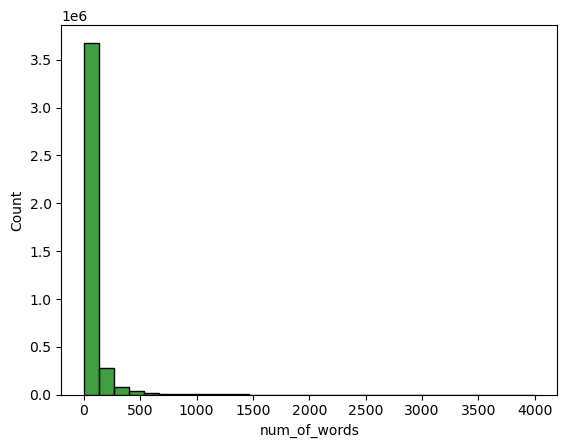

In [9]:
sns.histplot(data=dataset_pos_only, x='num_of_words',bins=30,color='green')

In [10]:
dataset_neg_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    780949.000000
mean         80.822900
std         127.803443
min           1.000000
1%            2.000000
10%           7.000000
25%          15.000000
50%          37.000000
75%          92.000000
90%         195.000000
99%         642.000000
max        1925.000000
Name: num_of_words, dtype: float64

<Axes: xlabel='num_of_words', ylabel='Count'>

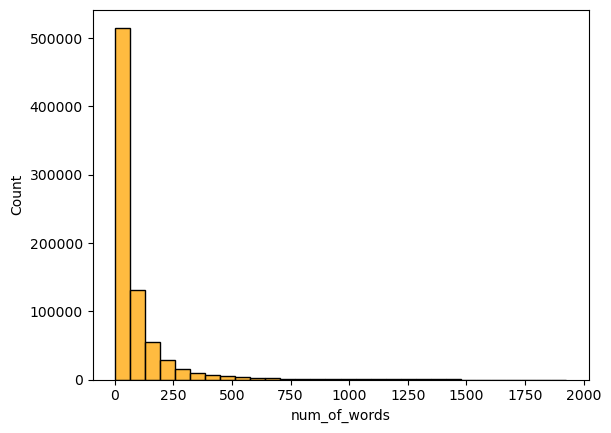

In [11]:
sns.histplot(data=dataset_neg_only, x='num_of_words',bins=30,color='orange')

The public dataset supports the distribution of the comments

- "Negative reviews are slightly longer than positive reviews, but the difference is negligible.". But seems the latter is not supported by the dataset we have.

- "Most games receive reviews with a median length of 205 characters, or 30 words.". The sentence is supported by the positive set and the overall dataset, but not on the negative set.

what if we remove comments less than 10 characters.

In [12]:
dataset_2 = dataset.copy()

dataset_2 = dataset_2[dataset_2['review_text'].str.len()>=10]

In [13]:
# first have all comments together

dataset_2['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    4.820282e+06
mean     6.272972e+01
std      1.082681e+02
min      1.000000e+00
1%       2.000000e+00
10%      6.000000e+00
25%      1.100000e+01
50%      2.700000e+01
75%      6.800000e+01
90%      1.500000e+02
99%      5.400000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

In [14]:
dataset_2_pos_only = dataset_2[dataset_2['review_score'] == 1]
dataset_2_neg_only = dataset_2[dataset_2['review_score'] == 0]

In [15]:
# describe the characteristics of the number of words

dataset_2_pos_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    4.046896e+06
mean     5.912335e+01
std      1.036389e+02
min      1.000000e+00
1%       2.000000e+00
10%      6.000000e+00
25%      1.100000e+01
50%      2.500000e+01
75%      6.300000e+01
90%      1.410000e+02
99%      5.150000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

<Axes: xlabel='num_of_words', ylabel='Count'>

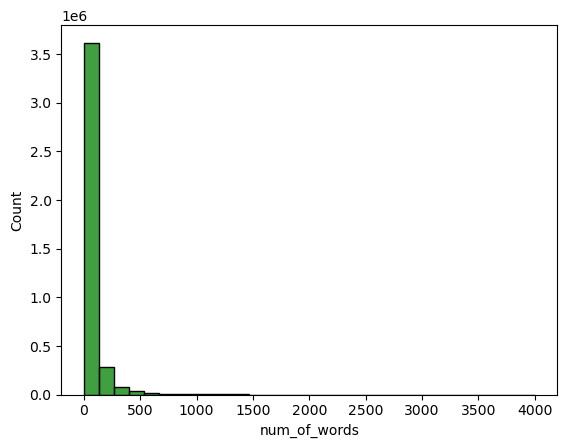

In [16]:
sns.histplot(data=dataset_2_pos_only, x='num_of_words',bins=30,color='green')

In [17]:
dataset_2_neg_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    773386.000000
mean         81.600765
std         128.183334
min           1.000000
1%            3.000000
10%           7.000000
25%          15.000000
50%          38.000000
75%          93.000000
90%         196.000000
99%         645.000000
max        1925.000000
Name: num_of_words, dtype: float64

In [18]:
# select some text for sample

dataset_2_neg_only[dataset_2_neg_only['num_of_words']==645].iloc[0]['review_text']

"After I bought Postal 2, i saw that there was a third one and it had modern-day graphics and i thought that was pretty cool and then I saw all the negative reviews except for the literally only postive review and i thought to myself, hmmm I wonder how bad this game is? Seeing as how the second one was badass and amazingly better than some of the AAA games we get served today, so i bought it, played it and beat it, and now i now why this game is slandered, even RWS has given up on this trainwreck but before i trash this game more i have to say there are parts of this game that are good but far from being awesome.  Like my review of Postal 2, this review will broken down in the same areas  Gameplay, Graphics, Sound and most importantly Story  Warning: this is my opinon and if anything offends you, i deeply apolgize  Gameplay 5/10: the overall gmeplay isn't all to bad, the controls aren't bad but they are a big difference from its predecessor, the main control feature i like about this g

In [24]:
for index, row in dataset_2_pos_only[dataset_2_pos_only['num_of_words'] > 512].sample(n=5).iterrows():
    print("\""+ row['review_text']+ "\",")
    print()

"Final Fantasy IV (PC version) is a remixed version of the original Final Fantasy IV from 1991, which was released as Final Fantasy II in North America for the SNES because Final Fantasy 2 and 3 were never released in North America at that time. Confused? Don't worry about it, lets just focus on this game. This version is a 'enhanced' port of the DS port of this game. On a personal level I feel the PSP version is a better port overall but again, it's just my opinion.  Graphics  Gone is the 2D engine of the original game from over 25(!) years ago, and we welcome a 3d engine. The graphics overall aren't that great but they are servicable. I much prefer sprite based graphics especially the older Final Fantasy's. The move to the 3D engine is fine but it creates certain problems. When you are wandering around it creates an almost 'zoomed in' feeling when navigating dungeons and towns. This issue may be the result of me playing the original version in my youth and it not feeling quite right.

In [25]:
for index, row in dataset_2_neg_only[dataset_2_neg_only['num_of_words'] > 512].sample(n=5).iterrows():
    print("\""+ row['review_text']+ "\",")
    print()

"First of all: I played this game with a controller, and didn't finish it yet, but there are just two of 13 chapters left, so there isn't much to see except of the end of the story. Also, this my personal view and opinion on the game.. :)  + Pros:  &gt; Graphics: The game looks just awesome with nice special effects, especially on the cutscenes! &gt; Setting: A steam-punkish / Sci-Fi game style, that i enjoyed personally, even if some monsters were a bit weird &gt; Character-Design: Characters with their own individual personality that are not like the old hero-stereotype char, even if they sometimes annoyed me because of all their 'what should i do?' moments &gt; Fight-System: New fresh system, something like the ATB system, which is based on different 'classes' which you change during the fights &gt; Leveling-System:  &gt; Port: Pretty okay, played the game with a controller and everything seems to be okay; sometimes the camera doesn't turn properly while running in one direction tho

<Axes: xlabel='num_of_words', ylabel='Count'>

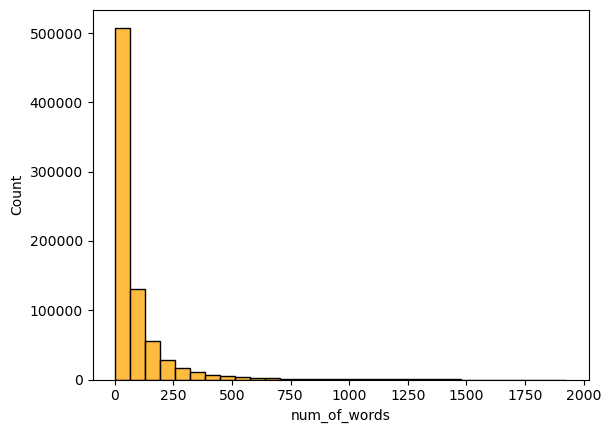

In [18]:
sns.histplot(data=dataset_2_neg_only, x='num_of_words',bins=30,color='orange')

Distribution of words in all review texts

We will perform that with stopwords and w/out stopwords

In [35]:
dataset['list_words'] = dataset['review_text'].apply(lambda x:str(x).split())

In [38]:
top = Counter([item for sublist in dataset['list_words'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,11970658
1,and,8062812
2,a,7584539
3,to,7520456
4,of,5805608
5,is,5377929
6,game,5022950
7,I,4888970
8,you,4550865
9,it,3720754


In [40]:
# create a dataset with cleaning performed

dataset_cleaned = dataset.copy(deep=True)

In [41]:
# clean basic characters
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [42]:
# remove numerics (maybe not required in BERT)
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [43]:
# remove emojis
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [44]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

In [45]:
# remove special symbols
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [46]:
# remove punctuation (just for analysis, maybe not required in BERT)
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### remove stopwords

Stopwords are words that occur frequently in a language and are often grammatical in nature, such as articles (e.g., "the," "a"), prepositions (e.g., "in," "on"), conjunctions (e.g., "and," "but"), and pronouns (e.g., "he," "she"). These words are necessary for constructing sentences and conveying grammatical structure, but they often do not contribute much to the overall meaning of the text.

- noise reduction
- Improved Analysis Accuracy
- faster processing

In [47]:
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

### use stemming to normalize words

Reduce the words to its stem to reduce dimension.
e.g. 

cared ----> care

university ----> univers

fairly ----> fair

easily ----> easili

singing ----> sing

sings ----> sing

sung ----> sung

singer ----> singer

sportingly ----> sport

In [48]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def stemming(text):
   stem=[]
   # stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [49]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(stemming)

In [50]:
cleaning(dataset_cleaned,'review_text')

In [51]:
dataset_cleaned['list_words'] = dataset_cleaned['review_text'].apply(lambda x:str(x).split())

In [54]:
top2 = Counter([item for sublist in dataset_cleaned['list_words'] for item in sublist])
temp2 = pd.DataFrame(top2.most_common(20))
temp2.columns = ['Common_words','count']
temp2.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,8396572
1,play,2441601
2,like,1686181
3,get,1411174
4,one,1191743
5,good,1174170
6,fun,1128581
7,time,1120780
8,great,1015484
9,realli,973986


<Axes: xlabel='count', ylabel='Common_words'>

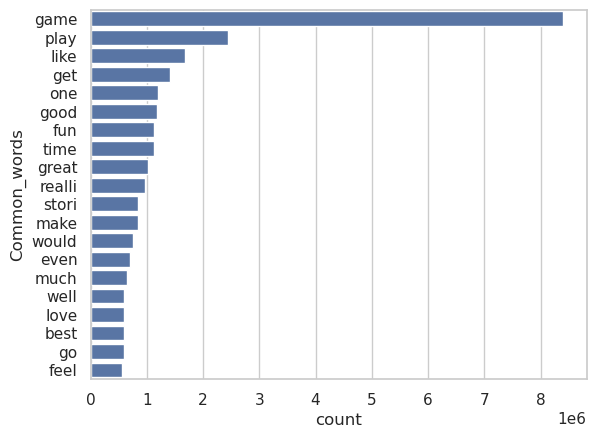

In [55]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp2)

If we break into positive and negative comments...

In [56]:
dataset_cleaned_pos_only = dataset_cleaned[dataset_cleaned['review_score'] == 1]
dataset_cleaned_neg_only = dataset_cleaned[dataset_cleaned['review_score'] == 0]

In [57]:
top3 = Counter([item for sublist in dataset_cleaned_pos_only['list_words'] for item in sublist])
temp3 = pd.DataFrame(top3.most_common(20))
temp3.columns = ['Common_words','count']
temp3.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,6786797
1,play,2007689
2,like,1349577
3,get,1096717
4,good,998402
5,fun,997776
6,one,990678
7,great,932459
8,time,883272
9,realli,783901


<Axes: xlabel='count', ylabel='Common_words'>

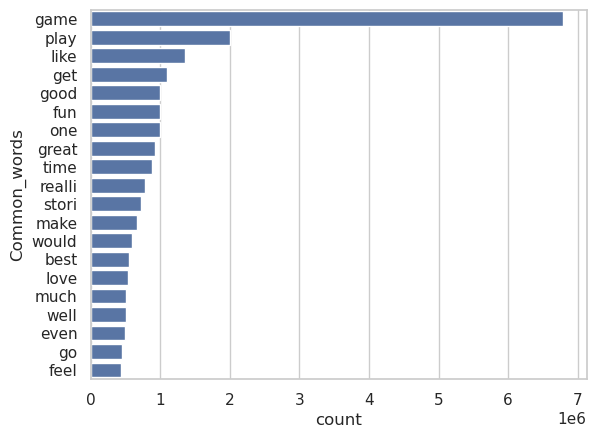

In [58]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp3)

In [59]:
top4 = Counter([item for sublist in dataset_cleaned_neg_only['list_words'] for item in sublist])
temp4 = pd.DataFrame(top4.most_common(20))
temp4.columns = ['Common_words','count']
temp4.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,1609775
1,play,433912
2,like,336604
3,get,314457
4,time,237508
5,even,206462
6,one,201065
7,realli,190085
8,good,175768
9,make,172682


<Axes: xlabel='count', ylabel='Common_words'>

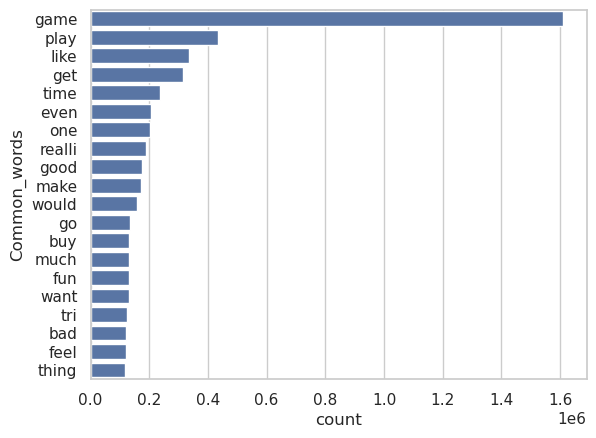

In [60]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp4)

what are the common words appeared in both top 20?

In [61]:
temp5 = pd.merge(temp3,temp4, how='inner', on=['Common_words'])

In [62]:
temp5

,Common_words,count_x,count_y
0,game,6786797,1609775
1,play,2007689,433912
2,like,1349577,336604
3,get,1096717,314457
4,good,998402,175768
5,fun,997776,130805
6,one,990678,201065
7,time,883272,237508
8,realli,783901,190085
9,make,662683,172682


looks almost the same as the overall dataset, as the positive comments are very domainant...

Due to hardware limitation, we will create a balanced dataset by randomly sampling positive comments in training

There are different methods in randomly selecting samples, yet the difference in performance are not significant (~0.01 in accuracy)  
E.g.: https://ruslanmv.com/blog/How-to-handle-imbalanced-text-data-in-Natural-Language-Processing

The undersampler in imbalanced-learning package will be applied on the training set

Then we may scrap new comments for validation on recent comments :D